In [1]:
import os
os.chdir(r"G:\uni class sessions\SAW_sari")

Number of nodes: 11
Number of edges: 121
Network density: 1.100


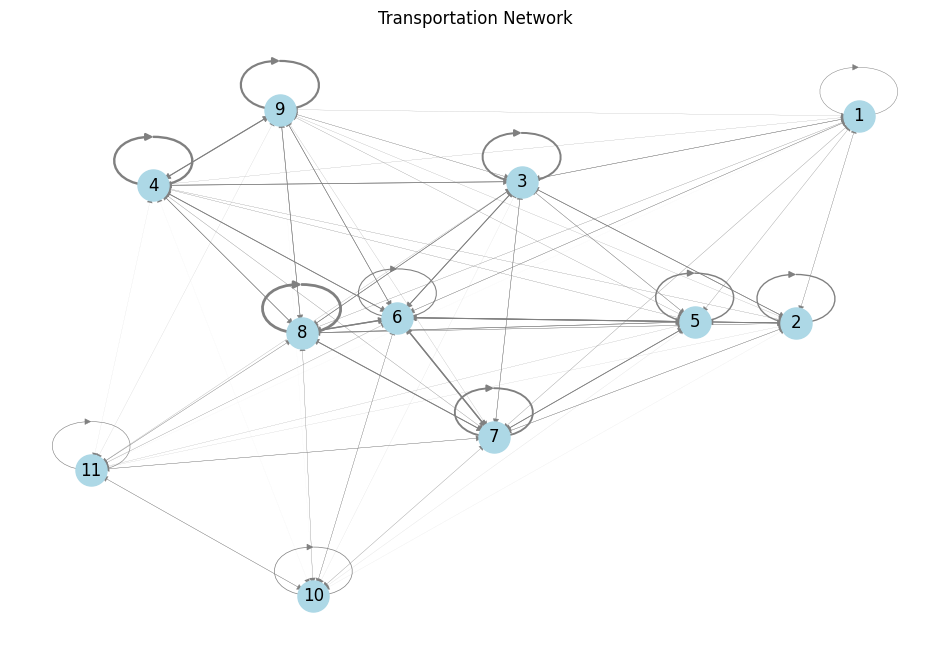

In [4]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_network_from_od_matrix(csv_file):
    """
    Create a network from an Origin-Destination matrix stored in a CSV file
    
    Parameters:
    csv_file (str): Path to the CSV file containing the OD matrix
    
    Returns:
    G (networkx.DiGraph): Directed network graph
    """
    try:
        # Read the CSV file without assuming any specific index
        matrix = pd.read_csv(csv_file)
        
        # If the first column contains the index but wasn't properly read
        if matrix.columns[0] == 'Unnamed: 0':
            # Set the first column as the index
            matrix.set_index(matrix.columns[0], inplace=True)
        
        # Convert all column names to strings if they're numbers
        matrix.columns = matrix.columns.astype(str)
        matrix.index = matrix.index.astype(str)
        
        # Create a directed graph
        G = nx.DiGraph()
        
        # Add nodes (zones)
        zones = matrix.columns
        for zone in zones:
            G.add_node(zone)
        
        # Add edges with weights
        for origin in zones:
            for destination in zones:
                try:
                    weight = float(matrix.loc[origin, destination])
                    if weight > 0:  # Only add edges where there are trips
                        G.add_edge(origin, destination, weight=weight)
                except ValueError:
                    print(f"Warning: Invalid value at origin {origin}, destination {destination}")
                    continue
        
        return G
    
    except Exception as e:
        print(f"Error reading the CSV file: {str(e)}")
        print("\nDebug information:")
        print("First few lines of the CSV file:")
        with open(csv_file, 'r') as f:
            print(f.readline())  # Header
            print(f.readline())  # First data row
        return None

def visualize_network(G):
    """
    Visualize the network with edge weights represented by line thickness
    """
    if G is None:
        print("No graph to visualize")
        return
    
    plt.figure(figsize=(12, 8))
    
    # Create layout
    pos = nx.spring_layout(G)
    
    # Get edge weights for line thickness
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    if weights:  # Check if there are any edges
        # Normalize weights for visualization
        max_weight = max(weights)
        normalized_weights = [2 * w/max_weight for w in weights]
        
        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                              node_size=500)
        nx.draw_networkx_edges(G, pos, width=normalized_weights,
                              edge_color='gray')
        nx.draw_networkx_labels(G, pos)
        
        plt.title("Transportation Network")
        plt.axis('off')
    else:
        print("No edges in the graph to visualize")

# Example usage:
if __name__ == "__main__":
    # Replace 'od_matrix.csv' with your actual file name
    network = create_network_from_od_matrix('OD_SARI.csv')
    
    if network:
        # Basic network statistics
        print(f"Number of nodes: {network.number_of_nodes()}")
        print(f"Number of edges: {network.number_of_edges()}")
        print(f"Network density: {nx.density(network):.3f}")
        
        # Visualize the network
        visualize_network(network)
        plt.show()

In [7]:
import geopandas as gpd

# Load the shapefile
gdf = gpd.read_file('zone2.shp')

# Print the column names
print(gdf.columns)

Index(['OBJECTID', 'Id', 'name', 'Shape_Leng', 'Shape_Area', 'areahec',
       'tejari_rat', 'mskn_kol', 'zone', 'geometry'],
      dtype='object')


Number of nodes: 11
Number of edges: 121
Network density: 1.100


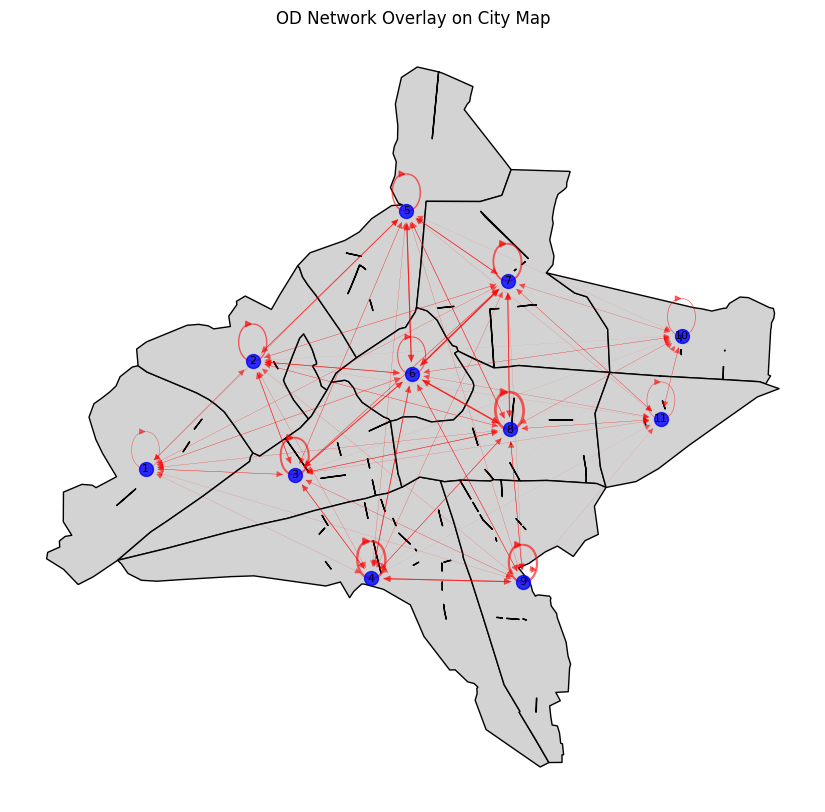

In [9]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def create_network_from_od_matrix(csv_file):
    """
    Create a network from an Origin-Destination matrix stored in a CSV file
    
    Parameters:
    csv_file (str): Path to the CSV file containing the OD matrix
    
    Returns:
    G (networkx.DiGraph): Directed network graph
    """
    try:
        matrix = pd.read_csv(csv_file)
        if matrix.columns[0] == 'Unnamed: 0':
            matrix.set_index(matrix.columns[0], inplace=True)
        
        matrix.columns = matrix.columns.astype(str)
        matrix.index = matrix.index.astype(str)
        G = nx.DiGraph()
        zones = matrix.columns
        for zone in zones:
            G.add_node(zone)
        for origin in zones:
            for destination in zones:
                try:
                    weight = float(matrix.loc[origin, destination])
                    if weight > 0:
                        G.add_edge(origin, destination, weight=weight)
                except ValueError:
                    continue
        return G
    except Exception as e:
        print(f"Error reading the CSV file: {str(e)}")
        return None

def visualize_network_on_map(G, shapefile, zone_column):
    """
    Visualize the network on the city map using the provided shapefile.
    
    Parameters:
    G (networkx.DiGraph): Directed network graph
    shapefile (str): Path to the shapefile
    zone_column (str): Column in the shapefile corresponding to zone identifiers
    """
    if G is None:
        print("No graph to visualize")
        return

    # Load the shapefile
    try:
        gdf = gpd.read_file(shapefile)
    except Exception as e:
        print(f"Error reading the shapefile: {str(e)}")
        return

    # Merge polygons for zones with the same identifier
    gdf = gdf.dissolve(by=zone_column)

    # Create a figure
    plt.figure(figsize=(12, 10))

    # Plot the base map
    gdf.plot(ax=plt.gca(), color='lightgrey', edgecolor='black')

    # Generate a layout for the network nodes based on the shapefile's centroids
    centroids = gdf.geometry.centroid
    pos = {str(zone): (centroid.x, centroid.y) for zone, centroid in zip(gdf.index, centroids)}

    # Get edge weights for visualization
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    if weights:
        max_weight = max(weights)
        normalized_weights = [2 * w / max_weight for w in weights]

        # Draw the network
        nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=100, alpha=0.8)
        nx.draw_networkx_edges(G, pos, width=normalized_weights, edge_color='red', alpha=0.6)
        nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')

    plt.title("OD Network Overlay on City Map")
    plt.axis('off')
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Replace with actual file paths
    csv_file = 'OD_SARI.csv'  # OD matrix file
    shapefile = 'zone2.shp'  # Shapefile
    zone_column = 'zone'  # Column in shapefile for zone identifiers

    # Create the network
    G = create_network_from_od_matrix(csv_file)

    if G:
        print(f"Number of nodes: {G.number_of_nodes()}")
        print(f"Number of edges: {G.number_of_edges()}")
        print(f"Network density: {nx.density(G):.3f}")

        # Visualize the network on the map
        visualize_network_on_map(G, shapefile, zone_column)